# Digital Geosciences Hackathon 2019
## Bayesian Regression Solution with MCMC

### Overview

The problem we attempted to solve is a regression problem in which we try to predict shear wave velocities (expressed as slowness, $DTS$) for wells which are missing this log type. During the hackathon we opted to develop a model using a synthetic dataset with the following data:

  * $DTS$ - Shear wave slowness ($\mu s / ft$)
  * $DTC$ - Compressional wave slowness ($\mu s / ft$)
  * $\rho_b$ - Bulk rock density  ($gm/cm^3$)
  * $x$ - The x coordinates of well log sample points
  * $y$ - The y coordinates of well log sample points
  * $z$ - The depths of well log sample points
  
Our model estimates $DTS$ using $x$, $y$, $z$, $DTC$, and $\rho_b$.

### Background Material

  * MCMC Introduction: https://www.tweag.io/posts/2019-10-25-mcmc-intro1.html
  * Various MCMC Examples (implemented in Python): https://docs.pymc.io/nb_examples/index.html
  * Bayesian Regression (implemented in Stan): https://mc-stan.org/docs/2_18/stan-users-guide/linear-regression.html
  

### Data Pre-processing

In [3]:
# Load jupyter extensions.
%load_ext autoreload

In [4]:
# Set jupyter to reload modules prior to execution.
%autoreload 2

In [17]:
# Python dependencies
import os

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from theano import shared

The data for all well logs in our dataset is already prepared as a csv file and can be read into a pandas DataFrame.

In [6]:
curve_df = pd.read_csv('../all_synthetic_well_logs.csv')
curve_df.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y
0,0,NaN,NaN,NaN,0.00,6782,8476.25,0.0
1,1,NaN,NaN,NaN,1.25,6782,8476.25,0.0
2,2,NaN,NaN,NaN,2.50,6782,8476.25,0.0
3,3,NaN,NaN,NaN,3.75,6782,8476.25,0.0
4,4,NaN,NaN,NaN,5.00,6782,8476.25,0.0


For fitting our model, we need to drop all rows with missing (na) values:

In [8]:
curve_df = curve_df.dropna()
curve_df.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y
361,361,202.660803,1047.141755,1.950106,451.25,6782,8476.25,0.0
362,362,202.123242,1036.177384,1.951479,452.50,6782,8476.25,0.0
363,363,201.588524,1025.440245,1.952849,453.75,6782,8476.25,0.0
364,364,201.056628,1014.924170,1.954217,455.00,6782,8476.25,0.0
365,365,200.527532,1004.620786,1.955583,456.25,6782,8476.25,0.0


We split our model into a test and training dataset at the well level (as opposed to splitting on the measurement level). This allows for plotting of entire predicted DTS well logs which provides a nicer visual check on our model estimates.

In [9]:
wells = curve_df.well.unique()
train_wells, test_wells = train_test_split(wells, test_size=0.2)

# Get curve data and shuffle datasets.
train_curves = curve_df[curve_df.well.isin(train_wells)].sample(frac=1).reset_index(drop=True)
test_curves = curve_df[curve_df.well.isin(test_wells)].sample(frac=1).reset_index(drop=True)

### Data Analysis

Before building our model, we performed some preliminary checks on our dataset to try to better understand the natural relationships between our data:

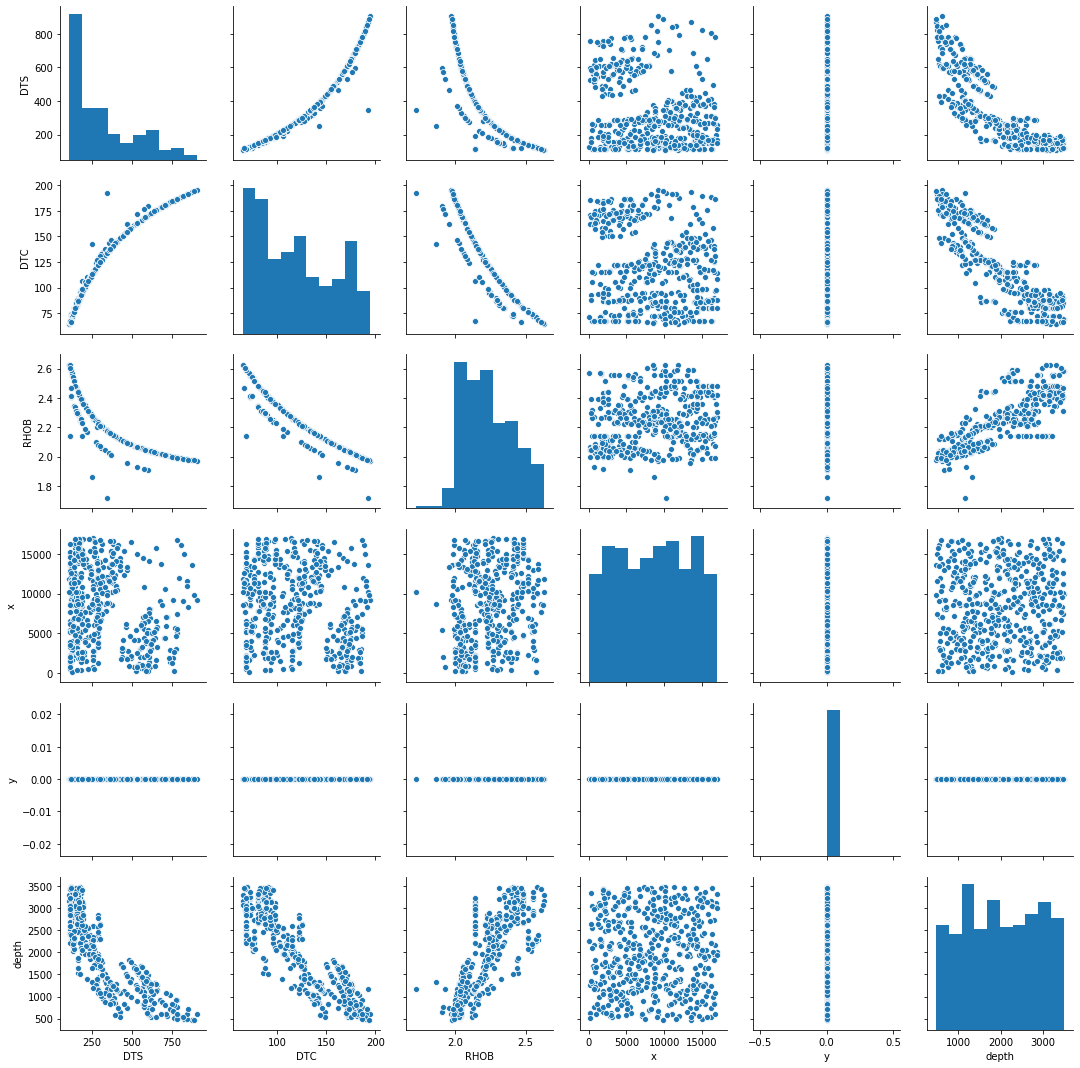

In [11]:
# Pair plots are a nice way of doing this. 
seaborn.pairplot(train_curves.sample(500)[["DTS", "DTC", "RHOB", "x", "y", "depth"]])
plt.show()

We can see some interesting features in our dataset: 

  1. Constant values for y - since our dataset is along a 2D profile, all y values are the same. We will therefore ignore y for the rest of our model.  Adding a term for y for real-world models can be done in a similar manner to how x is handled in this example. 
  2. A strong correlation between DTS and DTC. This correlation is partially an artifact of how our synthetic dataset was generated and will likely be far more noisy in real-world data.
  3. Non-linearities in the relationships DTC vs. DTS and RHOB vs. DTS
  4. Weak (and non-linear) correlation between x and the log curves.
  5. Wildly different numerical scales for each of our model parameters.
  
These observations will help inform us when we write our model.
  

For training our model, we don't really need the ENTIRE training dataset (it contains millions of data points). To make things computationaly efficient, we can just fit a smaller random sample from our training dataset:

In [13]:
train_subset = train_curves.sample(10000)

Now we can normalize our parameters. Normalization (via scaling and shifting) is done to improve the performance of our MCMC sampling.

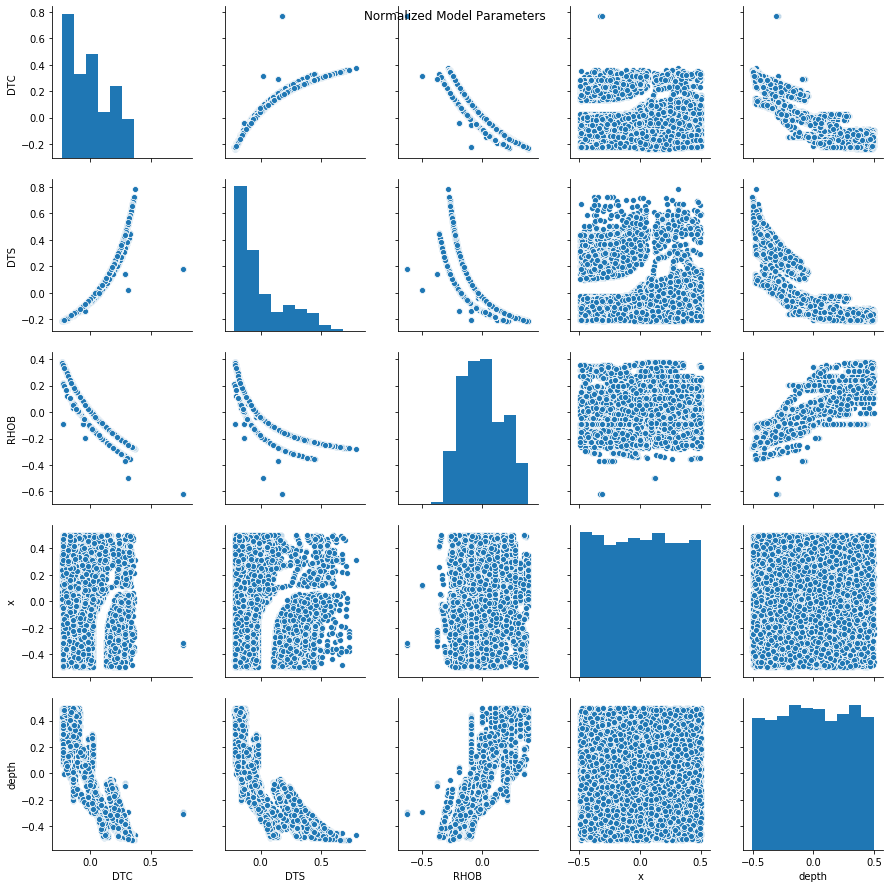

In [15]:
scale_factors = {}
shift_factors = {}

# You can add y here if there is actual data for it
norm_columns = ["DTC", "DTS", "RHOB", "x", "depth"]

# Storing the normalization terms here since we will need it to transform our posterior predictions
for c in norm_columns:
    scale_factors[c] = np.abs(train_subset[c].max() - train_subset[c].min())
    shift_factors[c] = train_subset[c].mean()
    train_subset.loc[:, c] = (train_subset.loc[:, c] - shift_factors[c]) / scale_factors[c]

pp = seaborn.pairplot(train_subset[norm_columns])
pp.fig.suptitle('Normalized Model Parameters')
plt.show()

### Model Definition and Training

With our data normalized, we're ready to define our MCMC model. For a good introduction to MCMC, I recommend taking a look at this introductory
article from Tweag: https://www.tweag.io/posts/2019-10-25-mcmc-intro1.html.

Our posterior distribution can be defined as:

$P(m | d) = \frac{P(d | m)*P(m)}{P(d)}$

Where:
  
 $ m = [DTS]$
 
 $ d = [DTC, RHOB, x, depth]$

This can be expressed in pymc3 as follows:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_depth, b_x, b_dtc, b_rho, alpha, sigma_mod]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:50<00:00, 35.17draws/s]
The acceptance probability does not match the target. It is 0.8970206872108879, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909457499468169, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9540032385989211, but should be close to 0.8. Try to increase the number of tuning steps.


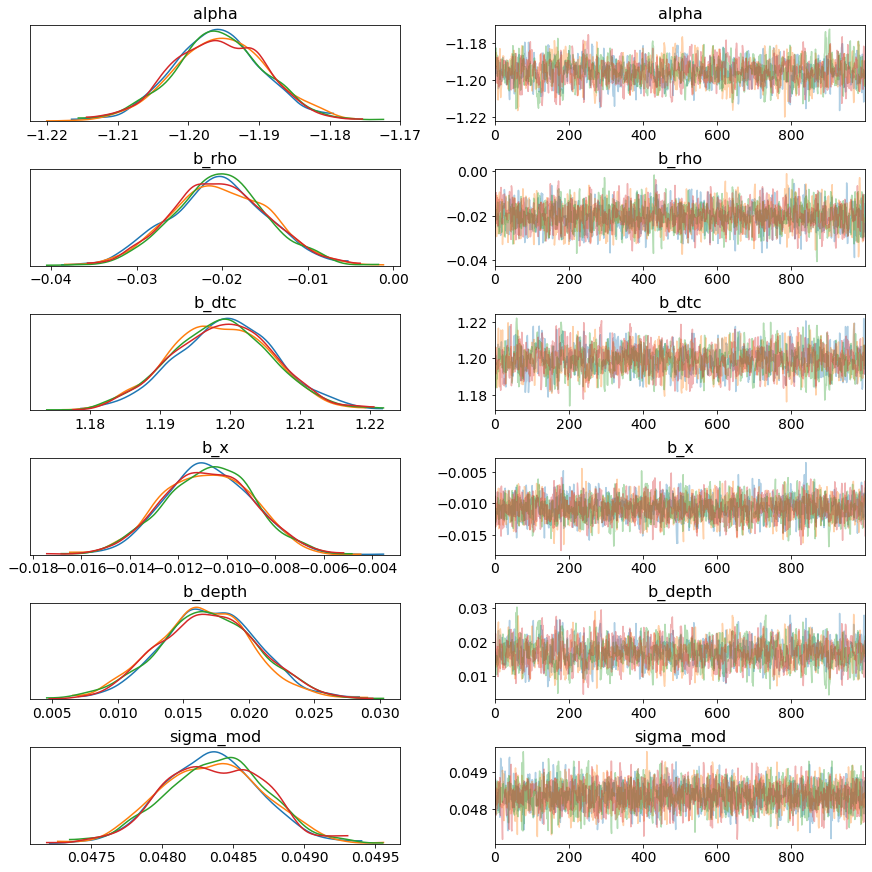

In [38]:
# You MUST define theano tensors for running the model.
#   we end up updating the values of these tensors to
#   generate our posterior predictions after training
#   our model.
shared_dtc = shared(train_subset.DTC.values)
shared_rhob = shared(train_subset.RHOB.values)
shared_x = shared(train_subset.x.values)
shared_y = shared(train_subset.y.values)
shared_depth = shared(train_subset.depth.values)
shared_dts = shared(train_subset.DTS.values)

with pm.Model() as linear_model:
    ## -- Prior definitions for model parameters --
    # Priors are one of the core tools in Bayesian statistics.
    # They allow you to encode a-priori beliefs into your
    # model with associated unceratinties.
    
    # sigma_mod is our modelization uncertainty
    sigma_mod = pm.HalfNormal('sigma_mod', 2)
    # intercept (alpha) and regression coefficients b_*
    alpha = pm.Normal('alpha', sigma=1)
    b_rho = pm.Normal('b_rho', sigma=1)
    b_dtc = pm.Normal('b_dtc', sigma=1)
    b_x = pm.Normal('b_x', sigma=1)
    # b_y = ...
    b_depth = pm.Normal('b_depth', sigma=1)
    
    # We can define nonlinear transformations if we think our
    #  features aren't well described by a simple linear relationship.
    #   Note: you need to use theano tensor math here (i.e. not numpy)
    dtc_transformed = theano.tensor.exp(shared_dtc)
    rhob_transformed = theano.tensor.exp(theano.tensor.neg(shared_rhob))
    
    
    #  -- Transform parameters into a predicted DTS --
    dts_pred = alpha + \
           (b_dtc * dtc_transformed) + \
           (b_rho * rhob_transformed) + \
           (b_depth * shared_depth) + \
           (b_x * shared_x)
    
    # -- Likelihood function definition --
    dts_obs = pm.Normal(
        'dts_obs', 
        mu=dts_pred, 
        sigma=sigma_mod,
        observed=shared_dts)
    
    # -- Sample! --
    trace = pm.sample(1000 , cores=4)
    
    # And, plot the traces for our model parameters
    pm.plots.traceplot(trace)


Our sampling seems to have succeeded - it exited without throwing any diagnostic warnings ("The acceptance probability does not match the target" is not a point of concern, we would mainly be concerned with divergent transitions and high Gelman-Rubin values for the NUTS sampler we are using) and our traces seem to be mixing well in the traceplot. 

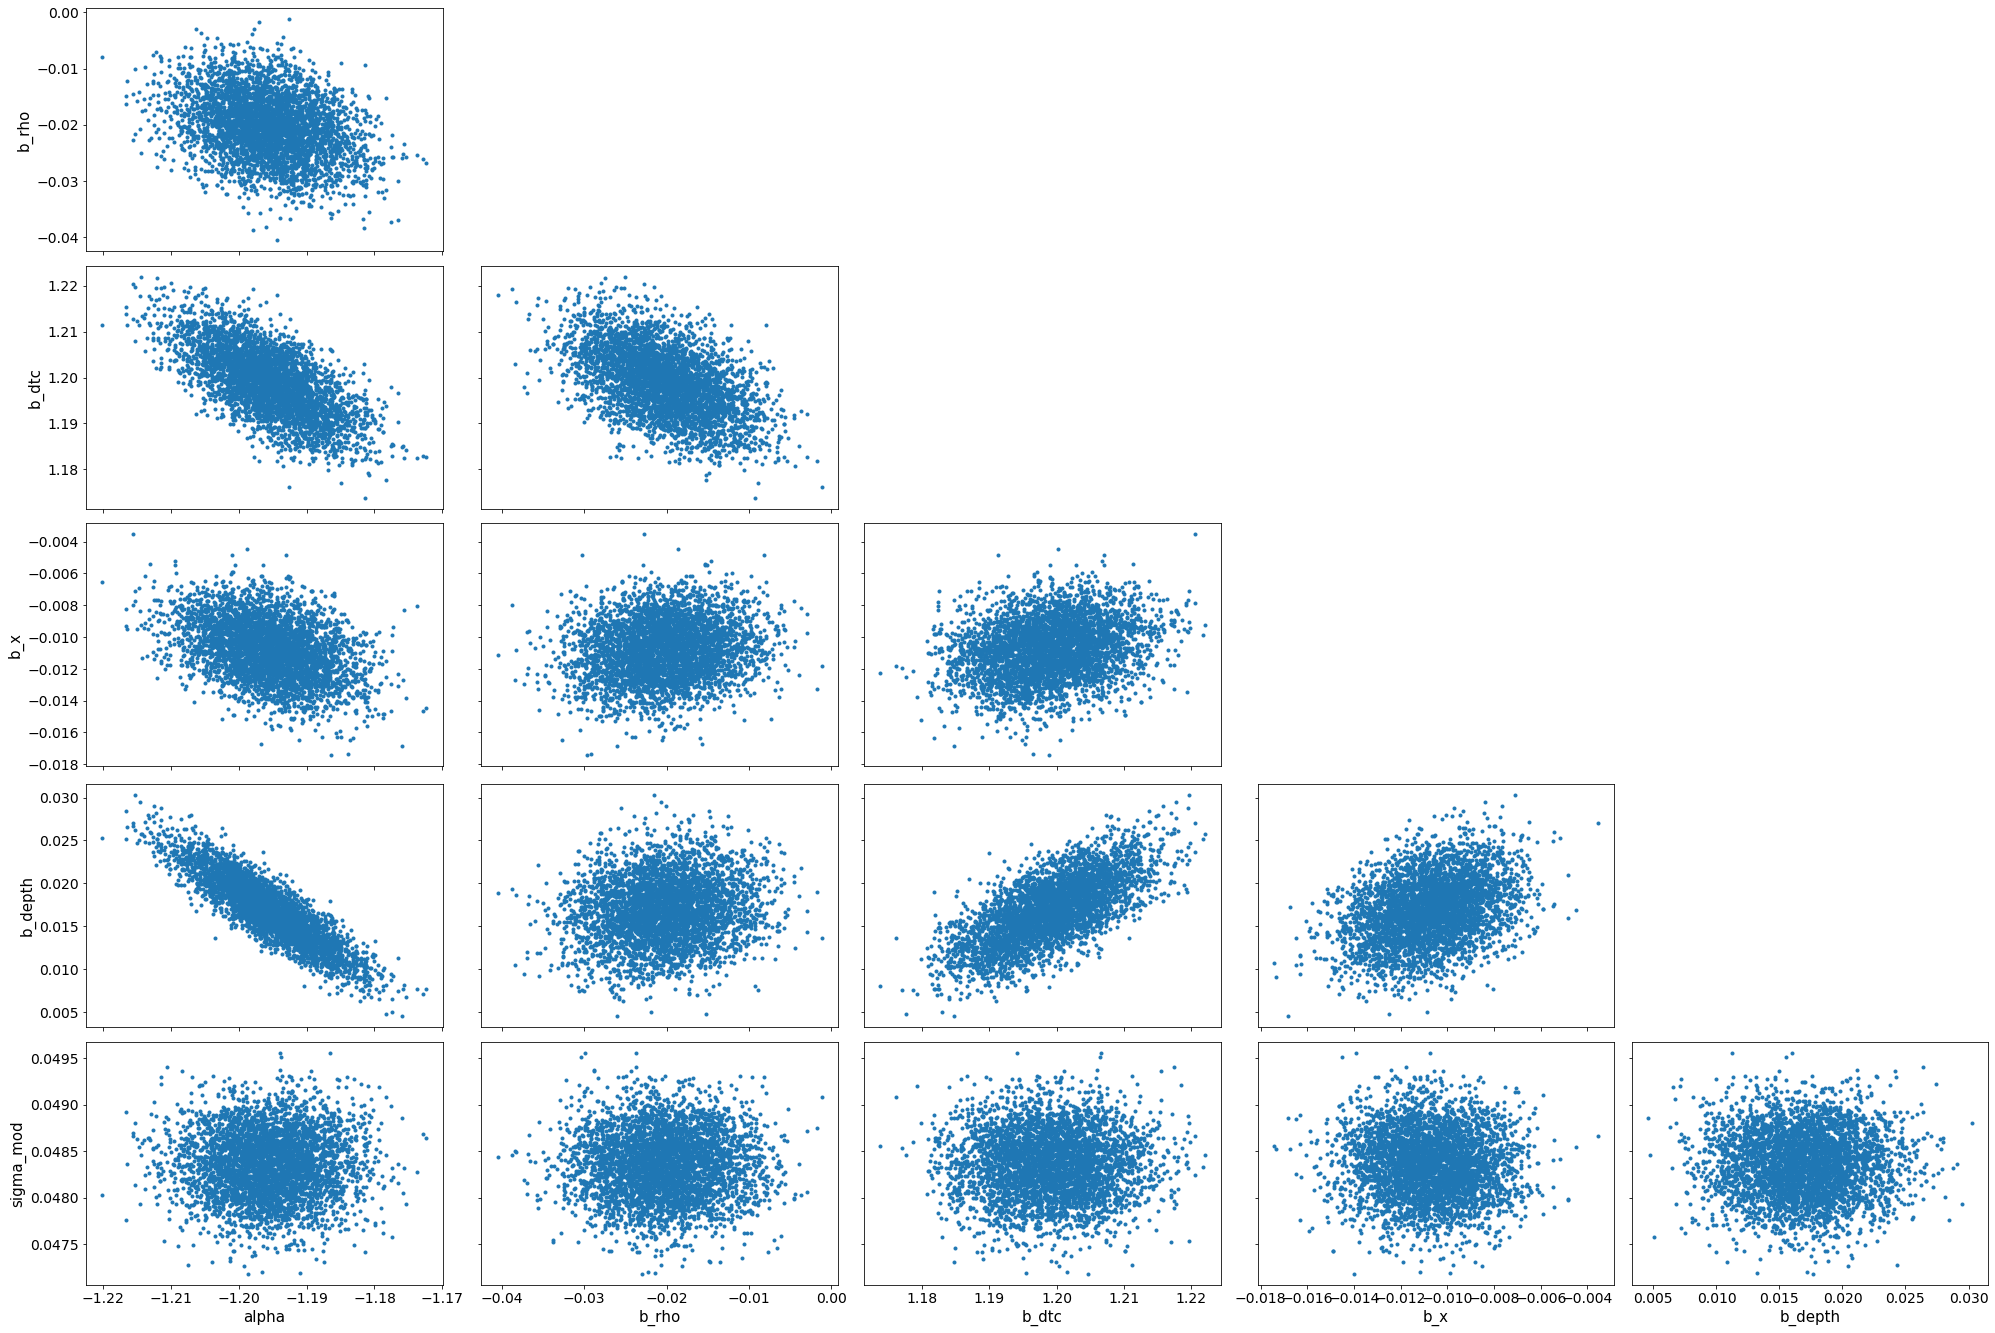

In [39]:
pm.plot_pair(trace)
plt.show()

### Generating Posterior Predictions for Test Dataset

For the sake of efficiency, we also downsampled our test dataset a bit:

In [91]:
# Note: test_wells is already randomized
ex_wells = test_wells[0:10]
ex_curves = test_curves.loc[test_curves.well.isin(ex_wells)]

# We also need to normalize our test data (by the same factor
#  as our training data) in order to be able to directly plug
#  it into our pymc3 model. There is probably a nicer way of
#  doing this...
for c in norm_columns:
    ex_curves.loc[:, c] = (ex_curves.loc[:, c] - shift_factors[c]) / scale_factors[c]

# Update data tensors with test data
shared_dtc.set_value(ex_curves.DTC.values)
shared_rhob.set_value(ex_curves.RHOB.values)
shared_x.set_value(ex_curves.x.values)
shared_y.set_value(ex_curves.y.values)
shared_depth.set_value(ex_curves.depth.values)

# Produce posterior predictions
ppc = pm.sample_posterior_predictive(trace, model=linear_model)
dts_pred_norm = ppc["dts_obs"]
dts_pred = dts_pred_norm*scale_factors["DTS"] + shift_factors["DTS"]

# We need to restore our data and labels to un-normalized space for plotting and further analysis:
for c in norm_columns:
    ex_curves.loc[:, c] = (ex_curves.loc[:, c]*scale_factors[c]) + shift_factors[c]

100%|██████████| 4000/4000 [01:22<00:00, 48.76it/s]


In [92]:
# Extract quantiles for predictions
percentiles = np.percentile(dts_pred, [2.5, 50, 97.5], axis=0)
ex_curves.loc[:, "PRED_DTS_2_5"] = percentiles[0,:]
ex_curves.loc[:, "PRED_DTS_50"] = percentiles[1,:]
ex_curves.loc[:, "PRED_DTS_97_5"] = percentiles[2,:]

# We can compute residual:
ex_curves.loc[:, "RESIDUAL_50"] = ex_curves["PRED_DTS_50"] - ex_curves["DTS"]

# We can also compute the MSE for our median posterior prediction:
p50_mse = (ex_curves["RESIDUAL_50"]**2.0).sum() / ex_curves.shape[0]

print("Median MSE: {}".format(p50_mse))

ex_curves.describe()

Median MSE: 1702.7708991937993


,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y,PRED_DTS_2_5,PRED_DTS_50,PRED_DTS_97_5,RESIDUAL_50
count,24400.000000,24400.000000,24400.000000,24400.000000,24400.000000,24400.000000,24400.000000,24400.0,24400.000000,24400.000000,24400.000000,24400.000000
mean,1580.500000,117.513582,314.603615,2.241652,1975.625000,7508.600000,9384.500000,0.0,220.842513,315.063866,409.308928,0.460251
std,704.381703,37.287290,202.427106,0.168790,880.477129,3463.424065,4329.280081,0.0,193.980552,193.973179,193.975633,41.262923
min,361.000000,64.851457,108.780103,1.719999,451.250000,726.000000,906.250000,0.0,-34.176430,63.255230,155.085226,-239.520496
25%,970.750000,86.102217,163.301306,2.132471,1213.437500,5659.000000,7072.500000,0.0,59.238707,153.237991,247.442960,-19.953455
50%,1580.500000,115.019565,259.626787,2.229637,1975.625000,7643.500000,9553.125000,0.0,192.280007,286.469124,380.808029,5.407856
75%,2190.250000,141.991195,385.843877,2.360000,2737.812500,10044.000000,12553.750000,0.0,328.050466,422.185550,516.359152,32.047392
max,2800.000000,202.660803,1047.141755,2.627000,3500.000000,12777.000000,15970.000000,0.0,721.259237,816.464179,911.956229,389.929226


In [93]:
# Grab one example well
example_well_1 = ex_wells[0]
pred_well_1 = ex_curves.loc[ex_curves.well == example_well_1]
pred_well_1 = pred_well_1.sort_values('depth')
pred_well_1.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y,PRED_DTS_2_5,PRED_DTS_50,PRED_DTS_97_5,RESIDUAL_50
1269975,361,202.660803,1047.141755,1.950106,451.25,3814,4766.25,0.0,721.080042,815.043144,904.772650,-232.098611
5742630,362,202.123242,1036.177384,1.951479,452.50,3814,4766.25,0.0,711.438630,809.696107,902.248454,-226.481278
4673588,363,201.588524,1025.440245,1.952849,453.75,3814,4766.25,0.0,711.653685,807.201425,901.310362,-218.238820
4974478,364,201.056628,1014.924170,1.954217,455.00,3814,4766.25,0.0,709.892290,804.069639,896.973903,-210.854531
5248688,365,200.527532,1004.620786,1.955583,456.25,3814,4766.25,0.0,704.805147,798.622601,895.176600,-205.998184


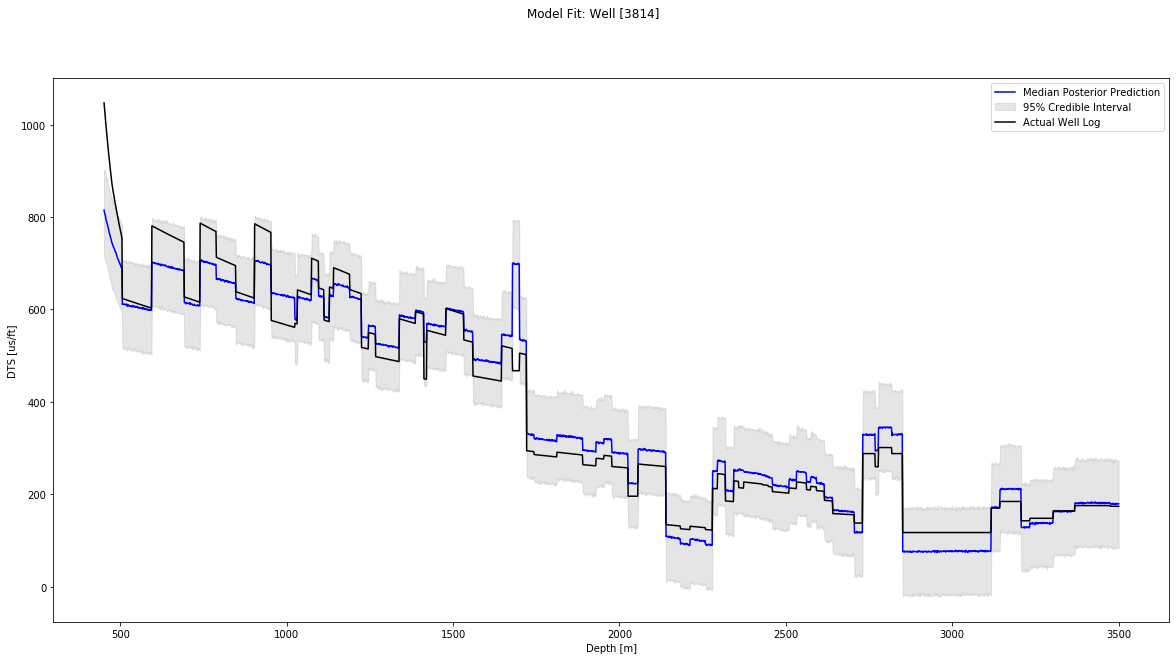

In [110]:
plt.figure(figsize=(20,10))
p_pred = plt.plot(pred_well_1.depth, pred_well_1.PRED_DTS_50, color='blue')
p_ci = plt.fill_between(pred_well_1.depth, pred_well_1.PRED_DTS_2_5, pred_well_1.PRED_DTS_97_5,
                         color='gray', alpha=0.2)
p_actual = plt.plot(pred_well_1.depth, pred_well_1.DTS, color='black')
plt.legend([p_pred[0], p_ci, p_actual[0]], ["Median Posterior Prediction", "95% Credible Interval", "Actual Well Log"])
plt.suptitle("Model Fit: Well {}".format(pred_well_1.well.unique()))
plt.ylabel("DTS [us/ft]")
plt.xlabel("Depth [m]")
plt.show()
